In [1]:
import pandas  as pd
import numpy as np
import os # used for checking if files/directories exist

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
x_col = 'Floor Slipperiness'
y_col = 'Shoe Slipperiness'
value_map = {0:'No Fall',1:'Fall'}

# Test data Frame
test = [
[1,1,1,1,1],
[1,1,1,1,1],
[1,1,0,1,1],
[0,0,0,1,1],
[0,0,1,1,1]]

# Make the data grid
df = pd.DataFrame(test)

# reset index so the above grip relates to the graph
df = df.reindex(index=df.index[::-1]).reset_index(drop=True)

df.reset_index(inplace=True)
# rename
df.rename({'index':y_col},inplace=True,axis='columns')
df.head(10)

,Shoe Slipperiness,0,1,2,3,4
0,0,0,0,1,1,1
1,1,0,0,0,1,1
2,2,1,1,0,1,1
3,3,1,1,1,1,1
4,4,1,1,1,1,1


In [11]:
# Melt it
df_format = pd.melt(df.reset_index(),id_vars=[y_col],value_vars=[0,1,2,3,4])
df_format.rename({'variable':x_col},inplace=True,axis='columns')
# remap the value column
df_format['value']=df_format['value'].map(value_map)
# df_format.rename()
# save it
df_format.to_csv('Slip_Data.csv',index=False)
df_format.head(5)

,Shoe Slipperiness,Floor Slipperiness,value
0,0,0,No Fall
1,1,0,No Fall
2,2,0,Fall
3,3,0,Fall
4,4,0,Fall


In [4]:
def print_data(df_format,x_col,y_col,plot_line=None):
    # remap the marker variables
    map_dict = {'No Fall':'o','Fall':'D'}
    color_dict = {'No Fall':'blue','Fall':'green'}
    size_dict = {'No Fall':150,'Fall':150}

    df_format[x_col] = pd.to_numeric(df_format[x_col])
    # df_format.plot.scatter(x='index',y='variable',figsize=(10,10),marker=df_format['value'].tolist())

    first = True
    for group in df_format['value'].unique():
        if first:
            ax = df_format.loc[df_format['value']==group,:].plot.scatter(x=x_col,y=y_col,
                            color=color_dict[group],figsize=(10,10),marker=map_dict[group],
                            s=size_dict[group],label=group)
            first = False
        else:
            df_format.loc[df_format['value']==group,:].plot.scatter(x=x_col,y=y_col,
                                    color=color_dict[group],marker=map_dict[group],ax=ax,s=size_dict[group],label=group)

        plt.title('The Effects of Falls vs. Surfaces',size=30,y=1.05)
    # Check if we need to plot a line
    if plot_line!=None:
        if plot_line[0]==y_col:
            ax.axhline(y=plot_line[1],linestyle='--',label='Best Split Line')
        else:
            ax.axvline(x=plot_line[1],linestyle='--',label='Best Split Line')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
              ncol=3, fancybox=True, shadow=True)
    ax.set_xlabel(x_col,size=25)
    ax.set_ylabel(y_col,size=25)
    plt.show()
# print_data(df_format)

In [5]:
def uniquecounts(df,col = 'value'):
    temp = df[col].value_counts().reset_index()
    temp.columns = [col,'Counts']
#     display(temp)
    return temp

In [6]:
# Make the decision code
# Gini Impurity
# The probability that a rondomly placed item will be in the wrong category
def giniimpurity(df,col='value'):
    total=len(df)
    counts = uniquecounts(df,col=col)
    entries = counts[col].unique() # Number of unique entries
    imp=0.0
    for k1 in entries:
        p1 = counts.loc[counts[col]==k1,'Counts'].sum()/total
        for k2 in entries:
            if k1==k2:continue
            p2=counts.loc[counts[col]==k2,'Counts'].sum()/total
            imp+=p1*p2
    return imp
# giniimpurity(df_format)

In [7]:
def dividedf(df,column,value):
    val_type = df[column].tolist()[-1]
#     print(val_type,pd.api.types.is_number(val_t))
    if pd.api.types.is_number(val_type):
        mask = df[column]>=value
    else:
        mask = df[column]==value
#     if isinstance(value,int) or isinstance(value,float):
#         mask = df[column]>=value
#     else:
#         mask = df[column]==value
    # Split into separate sets
    first_set = df.loc[mask,:].reset_index(drop=True)
    second_set = df.loc[~mask,:].reset_index(drop=True)
    return first_set, second_set

# set1, set2 = dividedf(df_format,'Shoe Grip',4)
# display(set1.head(2))
# display(set2.head(2))

In [8]:
def findbest(df,scorer=giniimpurity,val_col='value'):
    col_list = list(df.columns)
    # remove the value column
    col_list.remove(val_col)
    # What's the current score
    current_score = scorer(df,col=val_col)
    print("Initial Score: {}".format(current_score))
    
    # Iterate over the columns
    best_gain = 0.0
    best_criteria=None
    best_column=None
    for col in col_list:
        local_gain = 0.0
        local_column = None
        local_criteria = None
        unique_vals = df.loc[:,col].unique()
        for value in unique_vals:
            set1, set2 = dividedf(df,col,value)
            # We weight the change by the fraction of each resulting set (i.e. smaller set has lower contribution)
            set1_fraction = len(set1)/len(df)

            # calculate the gain
            gain = current_score-set1_fraction*scorer(set1,col=val_col)-(1-set1_fraction)*scorer(set2,col=val_col)
#             if len(set1)>0 and len(set2)>0:
#                 print(col,gain,value,set1_fraction)
            # Check if there's a gain, also we exclude data where there is no split (i.e. all data in one set)
            if gain>local_gain and len(set1)>0 and len(set2)>0:
                local_gain=gain
                local_column = col
                local_criteria = value
            if gain>best_gain and len(set1)>0 and len(set2)>0:
                best_gain = gain
                best_column = col
                best_criteria = value
                # update criteria to be inbetween
        next_best = df.loc[df[local_column]<local_criteria,local_column].max()
        local_criteria = (local_criteria+next_best)/2
        # Print local best set
        print("For Column {}, best gain was {} for split at {}".format(local_column,round(local_gain,4),local_criteria))
    # Update global best
    next_best = df.loc[df[best_column]<best_criteria,best_column].max()
    best_criteria = (best_criteria+next_best)/2    
    # Print Overal Best Find
    print("\nBest selection was:")
    print("For Column {}, best gain was {} for split at {}".format(best_column,round(best_gain,4),best_criteria))
    
    # do best cut and return
    set1, set2 = dividedf(df,best_column,best_criteria)
    set1_fraction = len(set1)/len(df)
    set1_score = scorer(set1,col=val_col)
    set2_score = scorer(set2,col=val_col)
    weighted_score = set1_fraction*set1_score-(1-set1_fraction)*set2_score
    print("First Group ({} rows) Score: {} and Second Group ({} rows) Score: {}".format(len(set1),round(set1_score,4),
                                                                                        len(set2),round(set2_score,4)))
    
    return set1, set2, best_column, best_criteria
    
findbest(df_format);

Initial Score: 0.3648
For Column Shoe Slipperiness, best gain was 0.0901 for split at 1.5
For Column Floor Slipperiness, best gain was 0.0768 for split at 2.5

Best selection was:
For Column Shoe Slipperiness, best gain was 0.0901 for split at 1.5
First Group (15 rows) Score: 0.1244 and Second Group (10 rows) Score: 0.5


Initial Score: 0.3648
For Column Shoe Slipperiness, best gain was 0.0901 for split at 1.5
For Column Floor Slipperiness, best gain was 0.0768 for split at 2.5

Best selection was:
For Column Shoe Slipperiness, best gain was 0.0901 for split at 1.5
First Group (15 rows) Score: 0.1244 and Second Group (10 rows) Score: 0.5


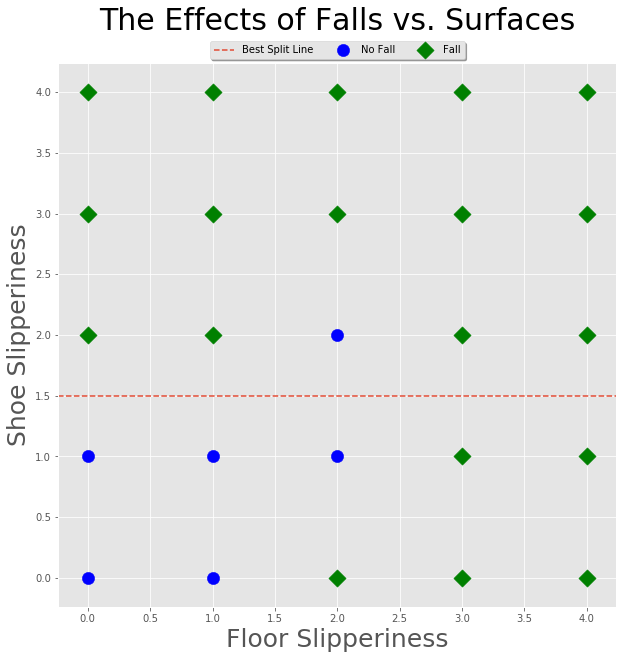

In [9]:
def plot_best_split(df_format,x_col,y_col,col='value'):
    set1,set2,column,value = findbest(df_format)
    print_data(df_format,plot_line=(column,value),x_col=x_col,y_col=y_col)
    
plot_best_split(df_format,x_col=x_col,y_col=y_col)

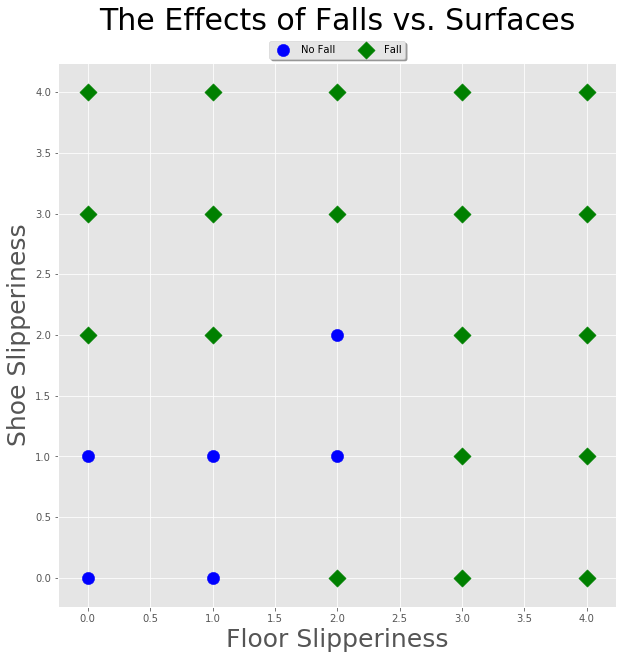

In [10]:
print_data(df_format,x_col=x_col,y_col=y_col)